* Input: embeddings in `io/` directory.
* Output: graphs

In [7]:
import json
from pathlib import Path
from ast import literal_eval
from typing import Tuple, Union, List
import numpy as np
import pandas as pd

import stats
import sys
import msgpack
from zipfile import ZipFile, ZipInfo
from pprint import pprint

In [8]:
n = 30
noise = "human"
DIR = Path("io/2021-02-17/")

In [9]:
# EM_DIR = DIR / "embeddings"
RESPONSES_DIR = DIR / "responses"
SALMON_DIR = Path.home() / "Developer" / "stsievert" / "salmon"
sys.path.append(str(SALMON_DIR / "examples"))

In [10]:
def _literal_eval(x):
    try:
        return literal_eval(x)
    except ValueError:
        return x

def _get_dict(s: str) -> dict:
    k_v = [kv.split("=") for kv in s.split("-")]
    k_v2 = {k: _literal_eval(v) for k, v in k_v}
    return k_v2

def _ident(d: dict) -> str:
    d2 = sorted(tuple(d.items()))
    d3 = [f"{k}={v}" for k, v in d2]
    return "-".join(d3)

In [11]:
def _get_config(name):
    return _get_dict(
        name.replace(".msgpack", "")
        .replace(".csv", "")
        .replace("responses*", "")
    )

def _get(file: Union[Path, bytes], history=False) -> Union[Tuple[np.ndarray, dict], List[dict]]:
    if isinstance(file, (Path, str)):
        with open(file, "rb") as f:
            data = msgpack.load(f)
    else:
        data = msgpack.loads(file)
    em = data.pop("embedding")
    meta = data.pop("meta")
    perf = data.pop("performance")
    if history:
        return data["history"]
    for k, v in perf.items():
        meta[f"perf__{k}"] = v
    return em, meta

In [12]:
data = []
with ZipFile(DIR / "embeddings-mu=0.05.zip", "r") as myzip:
    files = [f for f in myzip.filelist if ".msgpack" in f.filename]
    for f in myzip.filelist:
        datum, em = _get(myzip.read(f))
        if em["alg"] == "RandomSampling":
            data.append(_get(myzip.read(f)))

with ZipFile(DIR / "embeddings-mu=1e-4.zip", "r") as myzip:
    files = [f for f in myzip.filelist if ".msgpack" in f.filename]
    for f in myzip.filelist:
        datum, em = _get(myzip.read(f))
        if em["alg"] == "RR":
            data.append(_get(myzip.read(f)))

In [13]:
# keys = [k for k in RESPONSES_DIR.glob("*.csv") if "alg=RandomSampling" in str(k)]
# assert len(keys) == 1, len(keys)
# random_responses = pd.read_csv(keys[0])
# from sklearn.model_selection import train_test_split
# _, df_test = train_test_split(random_responses, test_size=0.2, random_state=42)
# print(keys)
# X_test = df_test[["head", "winner", "loser"]].to_numpy()

from run import _X_test
X_test = _X_test(n=n, num=20_000, noise=noise)

perf = [{**meta, **stats.collect(embedding, X_test)} for embedding, meta in data]
len(perf)

339

In [14]:
import datasets

In [15]:
df = pd.DataFrame(perf)

# fname = "history*R=10-alg=RR-d=2-dataset=strange_fruit-init=True-max_queries=20000-n=100-n_users=4-noise=constant-random_state=42-reaction_time=0.25-response_time=1.0.csv"
# fname = "history*R=10-alg=RR-d=2-dataset=strange_fruit-init=True-max_queries=20100-n=30-n_users=6-noise=constant-random_state=42-reaction_time=0.25-response_time=1.0.csv"
# fname = "history*R=10-alg=RR-d=2-dataset=alien_eggs-init=True-max_queries=30100-n=50-n_users=6-noise=human-random_state=42-reaction_time=0.25-response_time=1.0.csv"
# fname = "history*R=10-alg=RR-d=2-dataset=alien_eggs-init=True-max_queries=30100-n=30-n_users=10-noise=human-random_state=42-reaction_time=0.25-response_time=1.0.csv"
fname = "history*R=1-alg=RR-d=2-dataset=alien_eggs-init=True-max_queries=10100-n=30-n_users=3-noise=human-random_state=42-reaction_time=0.25-response_time=1.0.csv"
online = pd.read_csv(DIR / "history" / fname)
online["alg"] = online["perf__ident"] = "RR (online)"

df["sampling"] = df.ident.apply(lambda s: s.split("-")[0])
df["embedding"] = df.ident.apply(lambda s: s.split("-")[1])
online["sampling"] = "online"
online["embedding"] = "online"
df = pd.concat((df, online))
print("df.shape =", df.shape)

df.head()

df.shape = (633, 67)


,responses*R,alg,d,dataset,init,max_queries,n,n_users,noise,random_state,...,nn_diff_p5,nn_diff_p1,embedding_error,embedding_rel_error,procrustes_disparity,noise_model,sampling,embedding,Unnamed: 0,R
0,1.0,RandomSampling,2,alien_eggs,True,20100,30,3,human,42,...,1.0,1.0,0.128533,0.128533,0.016521,NaN,random,CKL,NaN,NaN
1,1.0,RandomSampling,2,alien_eggs,True,20100,30,3,human,42,...,1.0,1.0,0.132722,0.132722,0.017615,NaN,random,CKL,NaN,NaN
2,1.0,RandomSampling,2,alien_eggs,True,20100,30,3,human,42,...,1.0,1.0,0.129538,0.129538,0.016780,NaN,random,CKL,NaN,NaN
3,1.0,RandomSampling,2,alien_eggs,True,20100,30,3,human,42,...,1.0,1.0,0.128987,0.128987,0.016638,NaN,random,CKL,NaN,NaN
4,1.0,RandomSampling,2,alien_eggs,True,20100,30,3,human,42,...,1.0,1.0,0.130172,0.130172,0.016945,NaN,random,CKL,NaN,NaN


In [16]:
df.alg.unique()

array(['RandomSampling', 'RR', 'RR (online)'], dtype=object)

In [17]:
df.columns

Index(['responses*R', 'alg', 'd', 'dataset', 'init', 'max_queries', 'n',
       'n_users', 'noise', 'random_state', 'reaction_time', 'response_time',
       'ident', 'est__noise_model', 'est__max_epochs', 'est__dwell',
       'est__module__mu', 'est__verbose', 'est__shuffle', 'n_train', 'n_test',
       'n_responses', 'perf__pf_calls', 'perf__num_answers',
       'perf__model_updates', 'perf__num_grad_comps', 'perf__answers_bytes',
       'perf__score_train', 'perf__loss_train', 'perf__k',
       'perf__elapsed_time', 'perf__train_data', 'perf__n', 'perf__d',
       'perf__max_epochs', 'perf__verbose', 'perf__ident', 'perf___epochs',
       'perf__last_score', 'perf__score_test', 'perf__loss_test',
       'perf___elapsed_time', 'accuracy', 'nn_diff_median', 'nn_diff_mean',
       'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90', 'nn_diff_p80',
       'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50', 'nn_diff_p40',
       'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10', 'nn_diff_p5', 'nn_di

In [18]:
HUE_ORDER = ["random", "active", "online"]

(0.0, 10.0)

(0.0, 10.0)

(0.0, 10.0)

(0.0, 10.0)

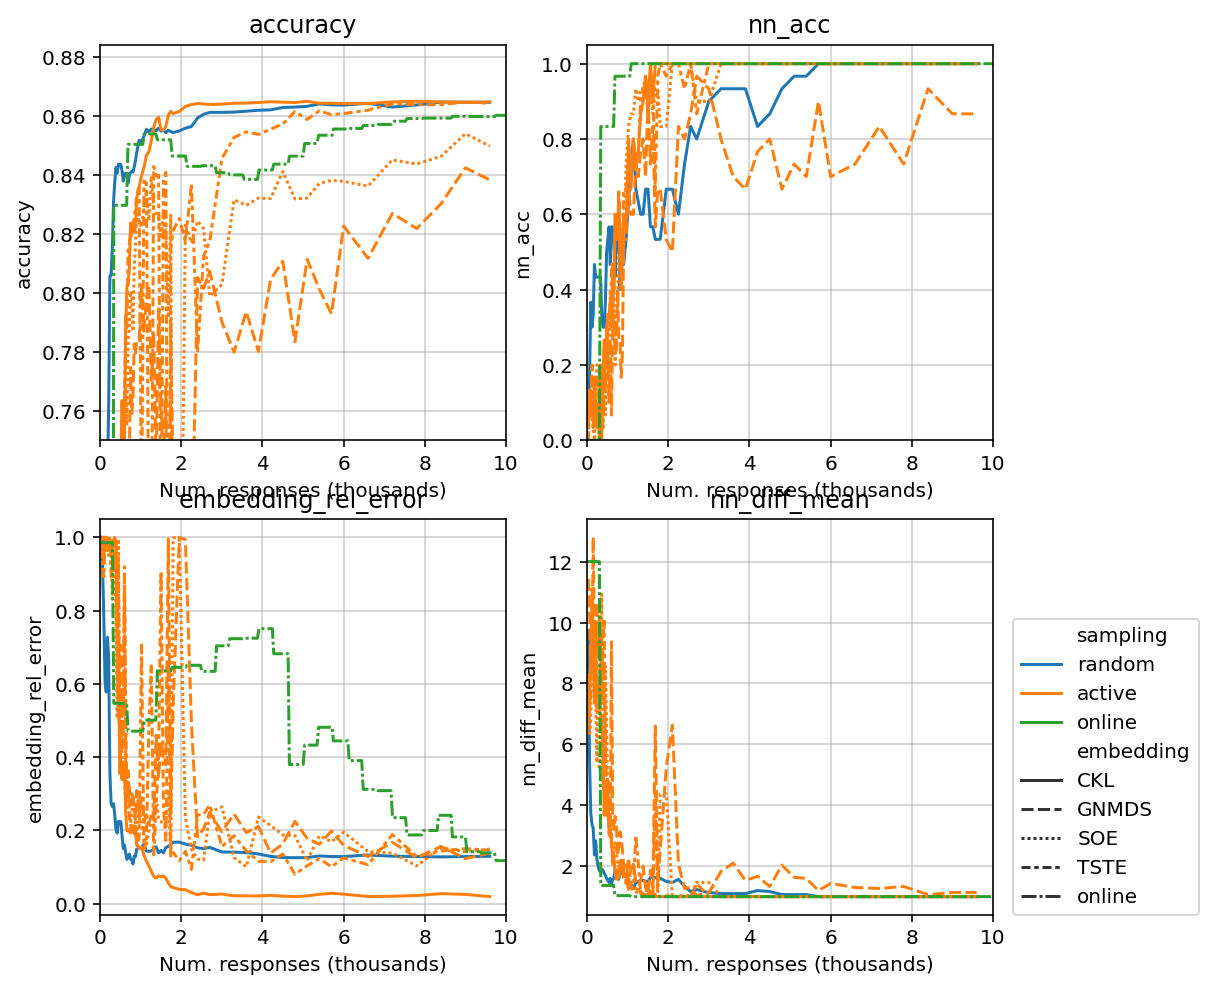

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

df["n_responses/1000"] = df.n_responses / 1000
Y = ["accuracy", "nn_acc", "embedding_rel_error", "nn_diff_mean"]
# Y = ["accuracy", "perf__loss_test", "embedding_rel_error", "nn_diff_mean"]

w = 4
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2 * w, 2.0 * w))
for k, (y, ax) in enumerate(zip(Y, axs.flatten())):
    ax = sns.lineplot(
        x="n_responses/1000",
        y=y,
        hue="sampling",
        style="embedding",
        hue_order=HUE_ORDER,
#         marker="o",
#         data=df,
        data=df,#[df.embedding.isin(["online", "CKL"])],
        ax=ax,
    )
    _ = ax.set_xlabel("Num. responses (thousands)")
    ax.grid(alpha=0.6)
    if k != 3:
        ax.legend_.remove()
    else:
        ax.legend(loc=(1.05, 0))
    _ = ax.set_title(y)
    
#     ax.set_xscale("log")
    if "accu" in y:
        _ = ax.set_ylim(0.75, None)
    elif "nn_acc" in y:
        _ = ax.set_ylim(0.0, 1.05)
    ax.set_xlim(0, 10)
#     ax.set_xlim(0.2, 20)


Text(0, 0.5, 'Accuracy')

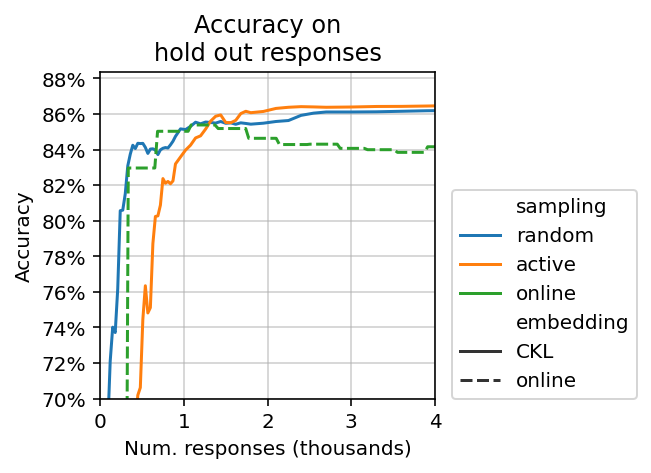

In [26]:
import matplotlib.ticker as ticker
show = df[df.embedding.isin(["online", "CKL"])].copy()
show["error"] = 1 - show["accuracy"]

prob = show["n"] * show["d"] * np.log(show["n"])
show["n_responses/prob"] = show["n_responses"] / prob

w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "accuracy"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
#     marker="o",
    data=show,
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax.set_xlim(0, 4)

_ = ax.set_ylim(0.70, None)
# _ = ax.set_title("Hold out performance")

ax.legend(loc=(1.05, 0))
ax.set_title("Accuracy on\nhold out responses")
ax.set_ylabel("Accuracy")
# fig.savefig("synth-eg-acc.png", dpi=300, bbox_inches="tight")

In [21]:
df.columns

Index(['responses*R', 'alg', 'd', 'dataset', 'init', 'max_queries', 'n',
       'n_users', 'noise', 'random_state', 'reaction_time', 'response_time',
       'ident', 'est__noise_model', 'est__max_epochs', 'est__dwell',
       'est__module__mu', 'est__verbose', 'est__shuffle', 'n_train', 'n_test',
       'n_responses', 'perf__pf_calls', 'perf__num_answers',
       'perf__model_updates', 'perf__num_grad_comps', 'perf__answers_bytes',
       'perf__score_train', 'perf__loss_train', 'perf__k',
       'perf__elapsed_time', 'perf__train_data', 'perf__n', 'perf__d',
       'perf__max_epochs', 'perf__verbose', 'perf__ident', 'perf___epochs',
       'perf__last_score', 'perf__score_test', 'perf__loss_test',
       'perf___elapsed_time', 'accuracy', 'nn_diff_median', 'nn_diff_mean',
       'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90', 'nn_diff_p80',
       'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50', 'nn_diff_p40',
       'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10', 'nn_diff_p5', 'nn_di

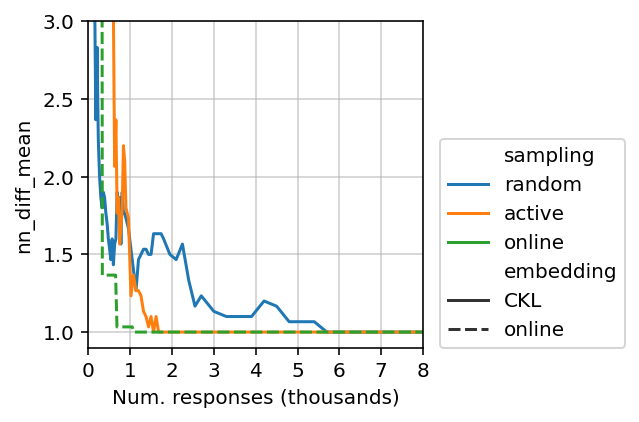

In [22]:
w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "nn_diff_mean"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylim(0.9, 3)
ax.set_xlim(0, 8)

ax.legend(loc=(1.05, 0))

(0.0, 6.0)

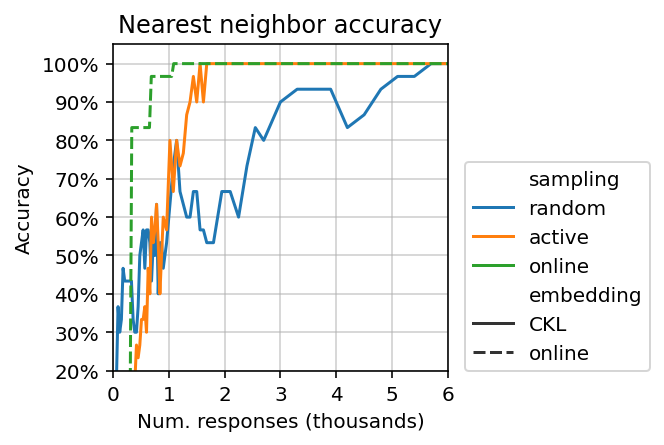

In [23]:
w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "nn_acc"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

_ = ax.set_ylim(0.20, 1.05)
_ = ax.set_xlim(0, 6)

ax.legend(loc=(1.05, 0))
ax.set_title("Nearest neighbor accuracy")
ax.set_ylabel("Accuracy")
# ax.set_xscale("log", base=2)
ax.set_xlim(0, None)

(0.0, 30.0)

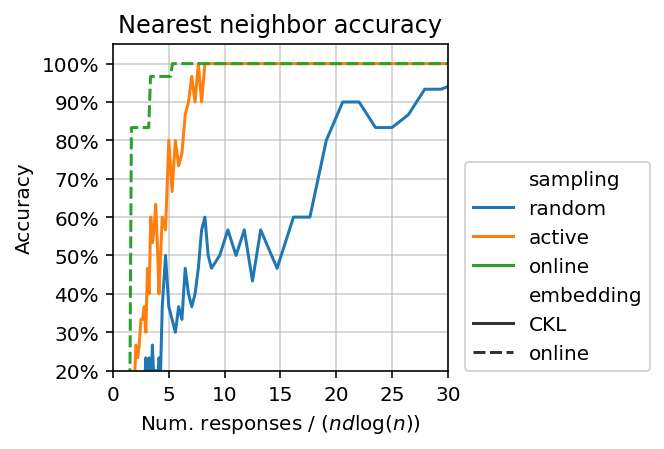

In [38]:
w = 3
y = "nn_acc"
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
ax = sns.lineplot(
    x="n_responses/prob",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
)
ax.set_xlabel("Num. responses / $(nd\log(n))$")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.set_xlim(0, 4)

_ = ax.set_ylim(0.20, 1.05)
_ = ax.set_xlim(0, 30)

ax.legend(loc=(1.05, 0))
ax.set_title("Nearest neighbor accuracy")
ax.set_ylabel("Accuracy")
# ax.set_xscale("log", base=2)
ax.set_xlim(0, None)

Text(0, 0.5, 'Accuracy')

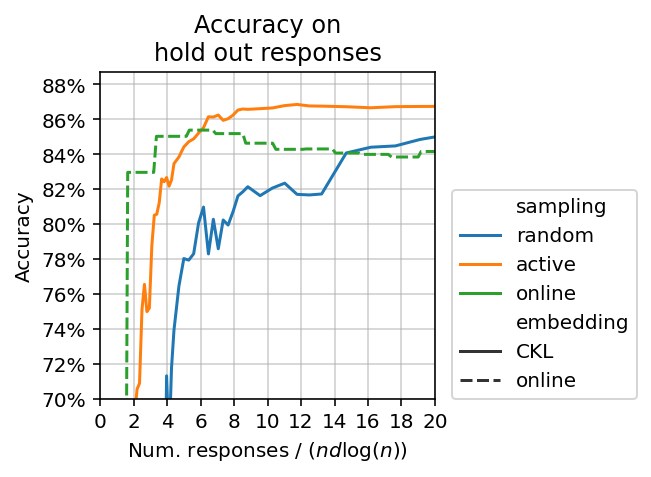

In [43]:
w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "accuracy"
ax = sns.lineplot(
    x="n_responses/prob",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
#     marker="o",
    data=show,
)
ax.set_xlabel("Num. responses / $(nd\log(n))$")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax.set_xlim(0, 20)

_ = ax.set_ylim(0.70, None)
# _ = ax.set_title("Hold out performance")

ax.legend(loc=(1.05, 0))
ax.set_title("Accuracy on\nhold out responses")
ax.set_ylabel("Accuracy")
# fig.savefig("synth-eg-acc.png", dpi=300, bbox_inches="tight")

Index(['responses*R', 'alg', 'd', 'dataset', 'init', 'max_queries', 'n',
       'n_users', 'noise', 'random_state', 'reaction_time', 'response_time',
       'ident', 'est__shuffle', 'est__noise_model', 'est__max_epochs',
       'est__dwell', 'n_train', 'n_test', 'n_responses', 'perf__pf_calls',
       'perf__num_answers', 'perf__model_updates', 'perf__num_grad_comps',
       'perf__answers_bytes', 'perf__score_train', 'perf__loss_train',
       'perf__k', 'perf__elapsed_time', 'perf__train_data', 'perf__n',
       'perf__d', 'perf__max_epochs', 'perf__verbose', 'perf__ident',
       'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_error', 'embeddi

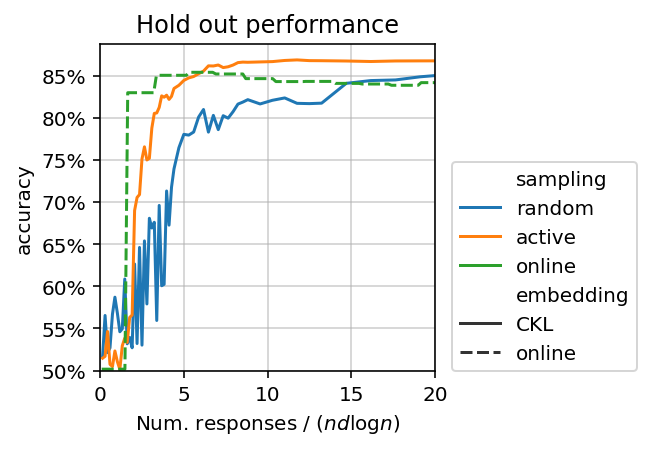

In [28]:
mport matplotlib.ticker as ticker
show = df[df.embedding.isin(["online", "CKL"])].copy()
show["error"] = 1 - show["accuracy"]

prob = show["n"] * show["d"] * np.log(show["n"])
show["n_responses/prob"] = show["n_responses"] / prob
print(show.columns)
assert np.allclose(show["n"], show["n"].iloc[0])
assert np.allclose(show["d"], show["d"].iloc[0])
n, d = show["n"].iloc[0], show["d"].iloc[0]

w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "accuracy"
ax = sns.lineplot(
    x="n_responses/prob",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
)

ax.set_xlabel("Num. responses / $(nd\log n)$")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))

_ = ax.set_ylim(0.50, None)
_ = ax.set_xlim(0, 20)
_ = ax.set_title("Hold out performance")

ax.legend(loc=(1.05, 0))

In [53]:
bound = 10 * n * d * np.log(n)

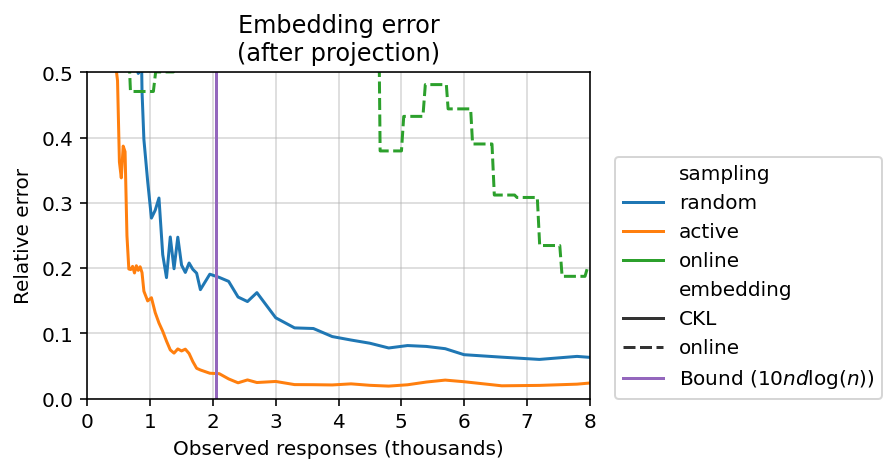

In [54]:
w = 3.0
fig, axs = plt.subplots(figsize=(1.5 * w, 1.0 * w))
y = "embedding_rel_error"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
#     ci=None,
#     estimator="max",
#     marker="o",
    data=show,
)
ax.grid(alpha=0.5)
ax.plot([bound / 1000, bound / 1000], [0, 1], "C4", label="Bound $(10nd\log(n))$")
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
# ax.xaxis.set_major_locator(plt.FixedLocator([0, 4, 10, 20, 30, 40, 50, 60]))
# ax.set_ylim(0.2, 1)
# ax.set_xscale("log")
# ax.set_xlim(0.5, 4)

# ax.set_xscale("log", base=2)
# ax.set_xlim(0.5, None)
ax.set_ylabel("Relative error")
ax.set_ylim(0, 0.5)
ax.set_xlim(0, 8)
ax.set_title("Embedding error\n(after projection)")
ax.set_xlabel("Observed responses (thousands)")
ax.legend(loc=(1.05, 0))

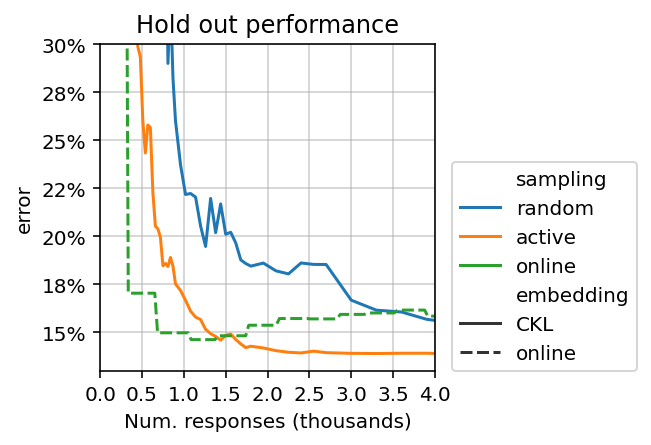

In [31]:
w = 1
fig, axs = plt.subplots(figsize=(3 * w, 3 * w))
y = "error"

ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
#     ci=None,
#     estimator="max",
#     marker="o",
    data=show,
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(0, 30)
ax.set_ylim(0.13, 0.30)
# ax.set_xlim(25, 35)
# ax.set_xscale("log", base=2)

ax.set_xlim(0.00, 4)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))

# _ = ax.set_ylim(0.70, None)
_ = ax.set_title("Hold out performance")

# ax.set_xscale("log", base=2)
# ax.xaxis.set_major_locator(ticker.LogLocator(base=2, numticks=15))
# ax.set_xlim(0.3, None)
ax.legend(loc=(1.05, 0))

In [32]:
_idx = show.pivot_table(
    index="sampling",
    values="accuracy",
    aggfunc=lambda x: np.abs(x - 0.82).idxmin(),
)
idx = {k: int(v) for k, v in dict(_idx["accuracy"]).items()}
for i in idx.values():
    s = show.loc[i, ["accuracy", "sampling", "n_responses"]]
    print(s)

   accuracy sampling  n_responses
3   0.81575   active          810
3   0.50170   online          126
accuracy       0.82965
sampling        online
n_responses        336
Name: 9, dtype: object
accuracy       0.8196
sampling       random
n_responses      2250
Name: 299, dtype: object


In [33]:
df.columns

Index(['responses*R', 'alg', 'd', 'dataset', 'init', 'max_queries', 'n',
       'n_users', 'noise', 'random_state', 'reaction_time', 'response_time',
       'ident', 'est__shuffle', 'est__noise_model', 'est__max_epochs',
       'est__dwell', 'n_train', 'n_test', 'n_responses', 'perf__pf_calls',
       'perf__num_answers', 'perf__model_updates', 'perf__num_grad_comps',
       'perf__answers_bytes', 'perf__score_train', 'perf__loss_train',
       'perf__k', 'perf__elapsed_time', 'perf__train_data', 'perf__n',
       'perf__d', 'perf__max_epochs', 'perf__verbose', 'perf__ident',
       'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_error', 'embeddi

(0.0, 5000.0)

(0.0, 5000.0)

(0.0, 5000.0)

(0.0, 5000.0)

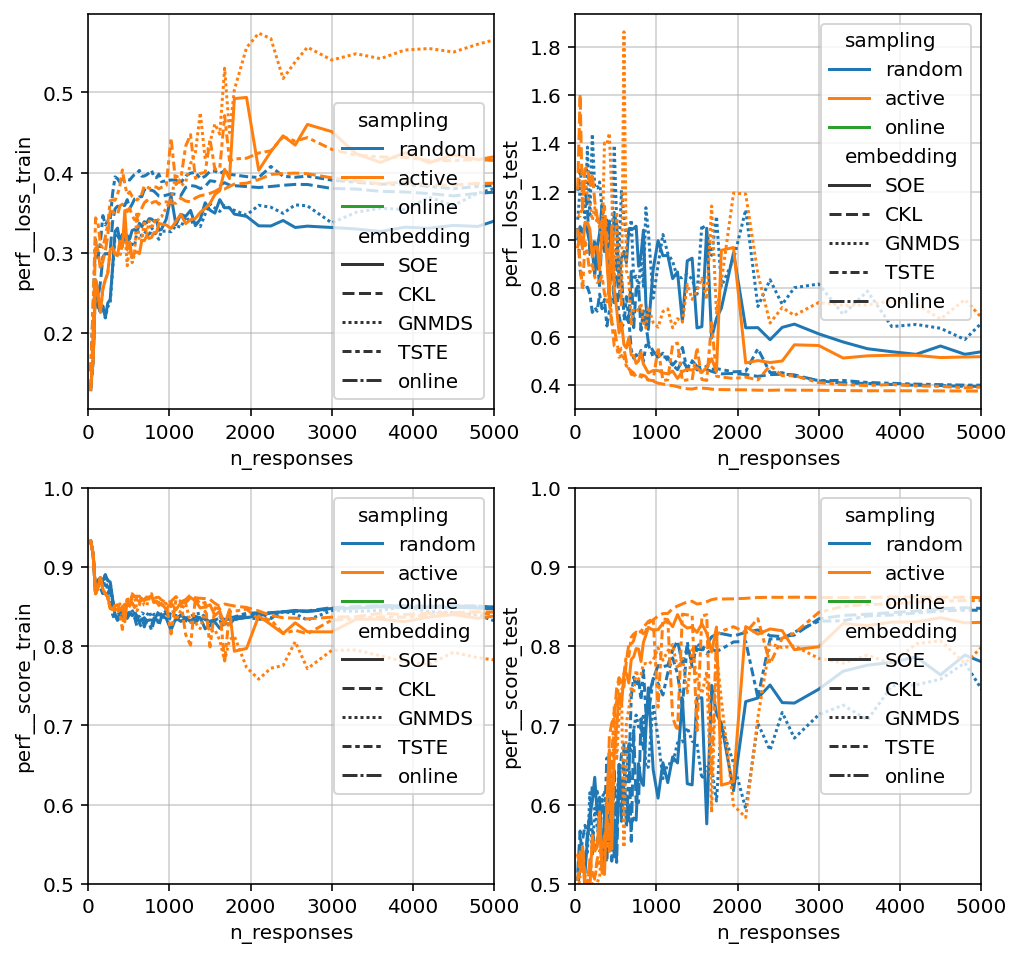

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

Y = ["accuracy", "nn_acc", "embedding_rel_error", "nn_diff_mean"]
Y = ["perf__loss_train", "perf__loss_test", "perf__score_train", "perf__score_test"]

w = 4
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2 * w, 2.0 * w))
for y, ax in zip(Y, axs.flatten()):
    ax = sns.lineplot(
        x="n_responses",
        y=y,
        hue="sampling",
        style="embedding",
        data=df,
        ax=ax,
    )
    ax.grid(alpha=0.6)
    if "score" in y:
        _ = ax.set_ylim(0.5, 1)
    ax.set_xlim(0, 5000)
#     ax.set_xscale("log")
#     _ = ax.set_title(y)
# axs[0][1].set_ylim(0, 2)